In [1]:
import glob
import librosa
import librosa.display
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, precision_score, f1_score
from hmmlearn import hmm

# Getting file paths and audio class 

In [2]:
def read_path_audio_and_target(is_train=True):
    paths, targets = [], []
    
    if is_train:
        name = 'train'
    else:
        name = 'valid'
        
    for cls in ['student', 'professor']:
        path = glob.glob(f'./dataset/{name}/{cls}/*')
    
        if cls == 'student':
            target = [0 for _ in range(len(path))]
        else:
            target = [1 for _ in range(len(path))]

        paths.extend(path)
        targets.extend(target)
    
    return paths, targets

In [3]:
paths_train, targets_train = read_path_audio_and_target(is_train=True)
paths_test, targets_test = read_path_audio_and_target(is_train=False)

In [4]:
print(paths_train[0])
sample_student, sr = librosa.load(paths_train[0])
display(Audio(sample_student, rate=sr))

./dataset/train/student/audio_1.wav


In [5]:
print(paths_train[-1])
sample_professor, sr = librosa.load(paths_train[-1])
display(Audio(sample_professor, rate=sr))

./dataset/train/professor/audio_5.wav


# Reshape audio and classes 

In [6]:
def reshape_sound_and_target(path_sound, targets, segment_size_t=1):
    """
    
    Parameters:
    path_sound, 
    targets, 
    segment_size_t: segment size in seconds
    """
    segments_sound, segments_target = [], []
    
    for i in range(len(path_sound)):
        # load
        y, sr = librosa.load(path_sound[i])

        signal_len = len(y) 
        # segment size in samples
        segment_size = int(segment_size_t * sr)  
        # Break signal into list of segments in a single-line Python code
        segments = [y[x:x + segment_size] for x in np.arange(0, signal_len, segment_size)]

        target = [targets[i] for _ in range(len(segments))]

        segments_sound.extend(segments)
        segments_target.extend(target)

    segments_sound = np.array(segments_sound)
    segments_target = np.array(segments_target)
    
    return segments_sound, segments_target, sr

In [7]:
segment_size_t = 0.25
segments_sound_train, segments_target_train, sr = reshape_sound_and_target(paths_train, targets_train, segment_size_t)
segments_sound_test, segments_target_test, _ = reshape_sound_and_target(paths_test, targets_test, segment_size_t)

/tmp/ipykernel_2186963/1097868759.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  segments_sound = np.array(segments_sound)


In [8]:
segments_sound_train.shape, segments_target_train.shape, sr

((476,), (476,), 22050)

# Create Feature

In [9]:

def create_feature(segments, sr):
    features = [
        ('chroma_stft', librosa.feature.chroma_stft),
        ('rms', librosa.feature.rms),
        ('spectral_centroid', librosa.feature.spectral_centroid),
        ('spectral_bandwidth', librosa.feature.spectral_bandwidth),
        ('spectral_rolloff', librosa.feature.spectral_rolloff),
        ('zero_crossing_rate', librosa.feature.zero_crossing_rate),
        ('mfcc', librosa.feature.mfcc)
    ]

    features_segmentation = []

    for seg in segments:
        feature_segmentation = []
        try:
            for name, func in features:

                if name in ['rms', 'zero_crossing_rate']:
                    y0 = func(y=seg)
                    feature_segmentation.append(np.mean(y0))

                elif name == 'mfcc':
                    y0 = func(y=seg, sr=sr, n_fft=min(len(seg), 2048))  # Limit n_fft to the length of the segment
                    for i, m in enumerate(y0, 1):
                        feature_segmentation.append(np.mean(m))

                else:
                    y0 = func(y=seg, sr=sr, n_fft=min(len(seg), 2048))  # Limit n_fft to the length of the segment
                    feature_segmentation.append(np.mean(y0))

        except Exception as e:
            print(e)

        features_segmentation.append(feature_segmentation)

    features_segmentation = np.array(features_segmentation)
    return features_segmentation


In [10]:
feature_train = create_feature(segments_sound_train, sr)
feature_test = create_feature(segments_sound_test, sr)

feature_train.shape, feature_test.shape

/home/lord/miniconda3/envs/ml_hackathon/lib/python3.9/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/home/lord/miniconda3/envs/ml_hackathon/lib/python3.9/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


((476, 26), (120, 26))

# StandardScaler

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(feature_train)

StandardScaler()

In [12]:
feature_train_scaler = scaler.transform(feature_train)
feature_test_scaler = scaler.transform(feature_test)

feature_train_scaler.shape, feature_test_scaler.shape

((476, 26), (120, 26))

## Histogram training data of each feuture for student (blue) and teacher (orange) 

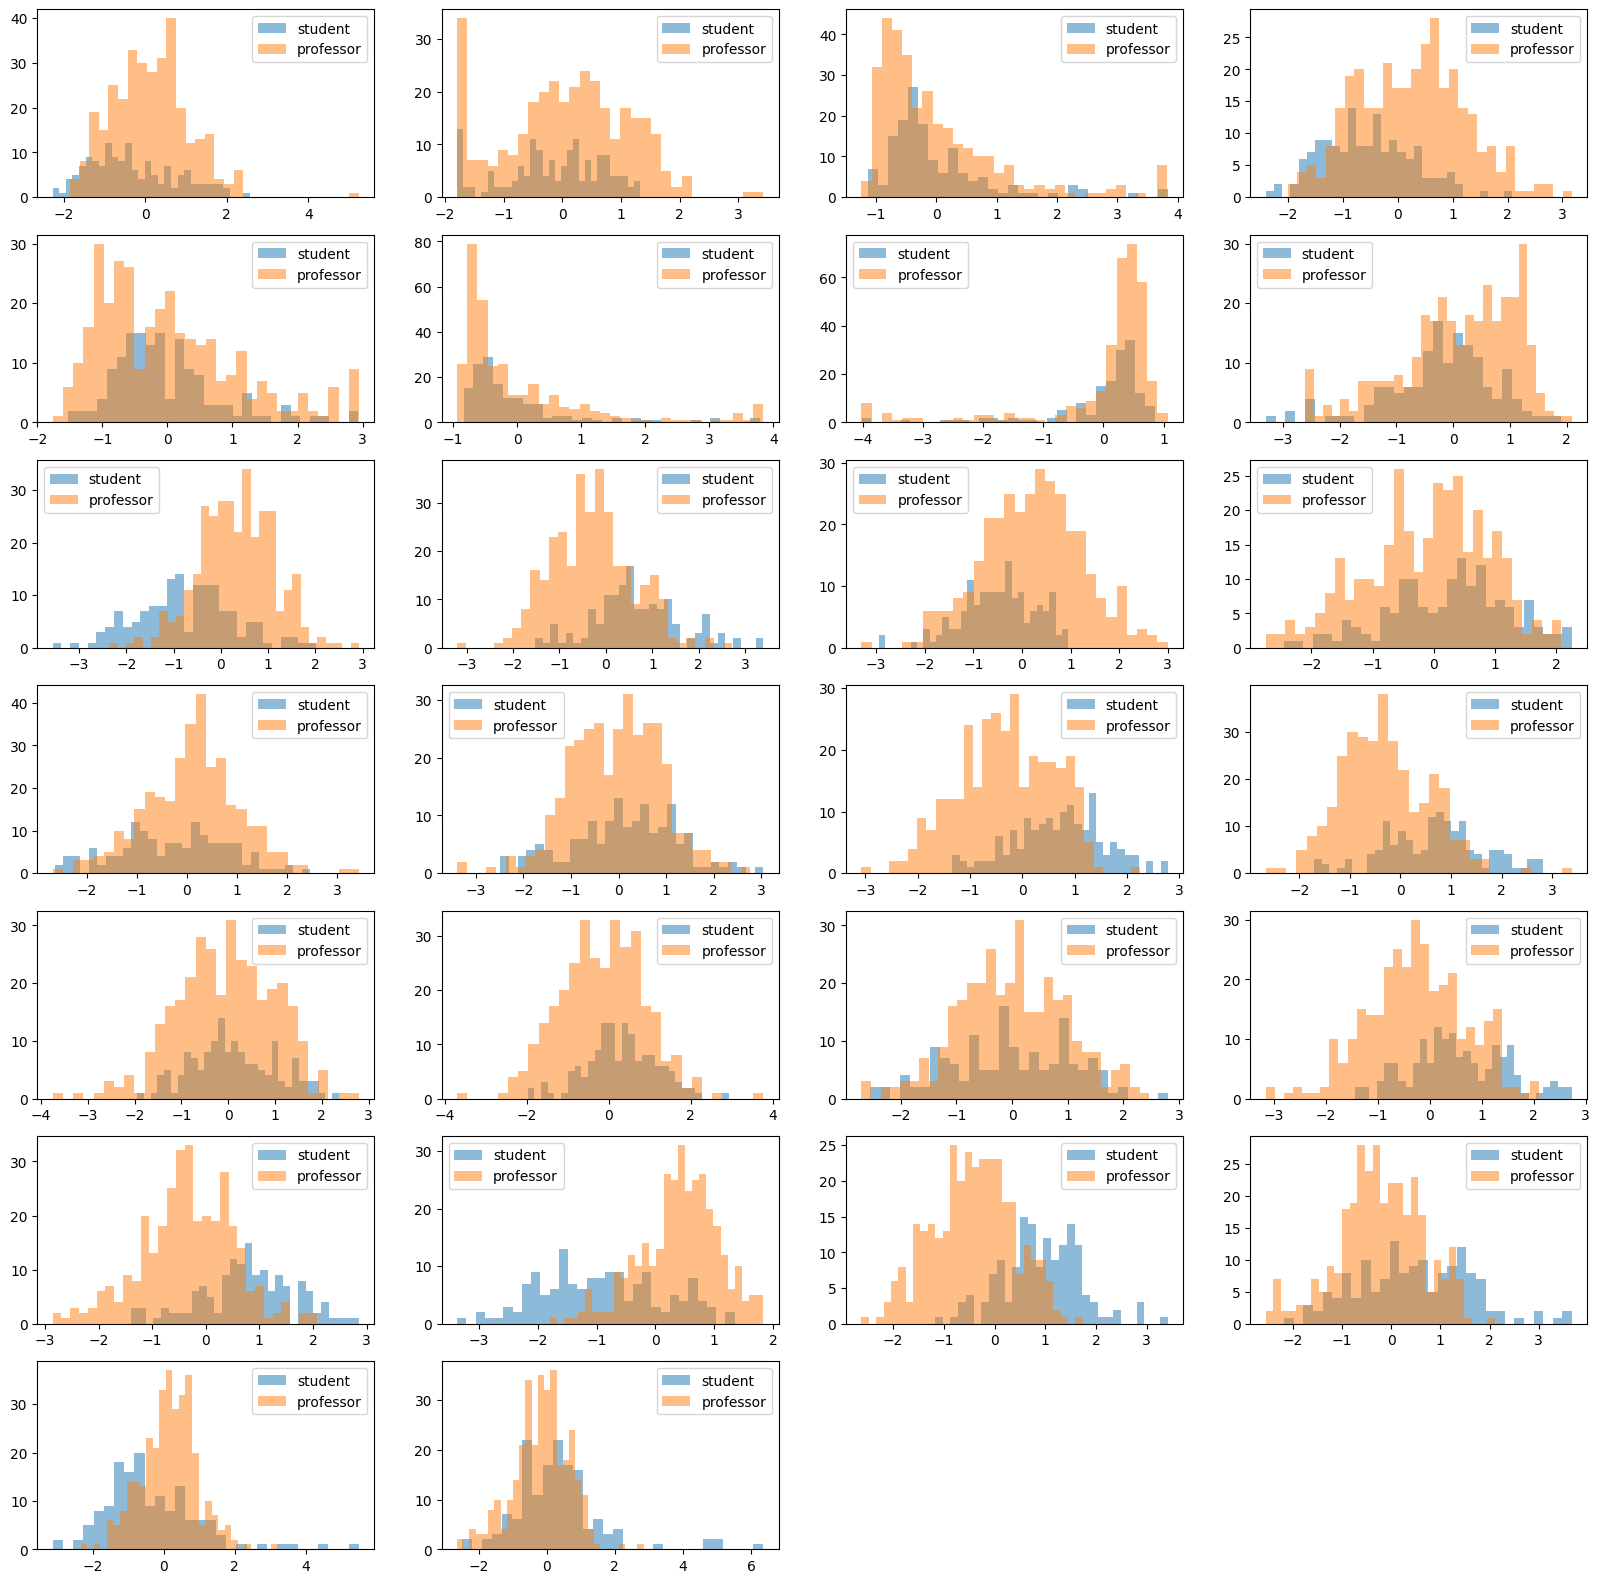

In [13]:
plt.figure(figsize=(20,20))
for i in range(0, feature_train_scaler.shape[1]):
    plt.subplot(7,4,i+1)
    plt.hist(feature_train_scaler[:,i][segments_target_train == 0], bins=30, alpha=0.5)
    plt.hist(feature_train_scaler[:,i][segments_target_train == 1], bins=30, alpha=0.5)
    plt.legend(['student', 'professor'])
plt.show()

# Model

In [14]:
num_speakers = 2

In [18]:
# Define parameter values to try
n_components_values = [3, 4, 5]
n_iter_values = [200, 300, 400]

best_score = 0.0
best_model = None

# Train models with different parameter values and evaluate on a validation set
for n_components in n_components_values:
    for n_iter in n_iter_values:
        models = [hmm.GaussianHMM(n_components=n_components, covariance_type="full", n_iter=n_iter) for _ in range(num_speakers)]

        for i in range(num_speakers):
            print(f"Training model with n_components={n_components}, n_iter={n_iter}, speaker {i}")
            models[i].fit(feature_train_scaler[segments_target_train==i])

        # Evaluate on the validation set
        scores = []
        for k in feature_test_scaler:
            scores.append([model.score(k.reshape(1, -1)) for model in models])

        pred = np.argmax(np.array(scores), axis=1)

        current_score = f1_score(segments_target_test, pred, average='weighted')

        print(f"Validation Score for n_components={n_components}, n_iter={n_iter}: {current_score}")

        # Update the best model if needed
        if current_score > best_score:
            best_f1_score = current_score
            best_model = models

Training model with n_components=3, n_iter=200, speaker 0
Training model with n_components=3, n_iter=200, speaker 1
Validation Score for n_components=3, n_iter=200: 0.5920000000000001
Training model with n_components=3, n_iter=300, speaker 0
Training model with n_components=3, n_iter=300, speaker 1


Model is not converging.  Current: -1916.536477015188 is not greater than -1903.7657286330198. Delta is -12.770748382168222


Validation Score for n_components=3, n_iter=300: 0.5547854785478548
Training model with n_components=3, n_iter=400, speaker 0
Training model with n_components=3, n_iter=400, speaker 1


Model is not converging.  Current: -262.89129522653906 is not greater than -262.8912162143912. Delta is -7.901214786443234e-05


Validation Score for n_components=3, n_iter=400: 0.15232067510548525
Training model with n_components=4, n_iter=200, speaker 0
Training model with n_components=4, n_iter=200, speaker 1


Model is not converging.  Current: -520.063227061339 is not greater than -114.04632159079746. Delta is -406.0169054705416


Validation Score for n_components=4, n_iter=200: 0.9496255291436014
Training model with n_components=4, n_iter=300, speaker 0
Training model with n_components=4, n_iter=300, speaker 1
Validation Score for n_components=4, n_iter=300: 0.7527462121212121
Training model with n_components=4, n_iter=400, speaker 0
Training model with n_components=4, n_iter=400, speaker 1
Validation Score for n_components=4, n_iter=400: 0.9145658263305322
Training model with n_components=5, n_iter=200, speaker 0
Training model with n_components=5, n_iter=200, speaker 1


Model is not converging.  Current: 1304.0382244535106 is not greater than 2097.808854880443. Delta is -793.7706304269325


Validation Score for n_components=5, n_iter=200: 0.7347338935574228
Training model with n_components=5, n_iter=300, speaker 0
Training model with n_components=5, n_iter=300, speaker 1


Model is not converging.  Current: -1037.6695094834745 is not greater than -823.4271421875648. Delta is -214.24236729590973


Validation Score for n_components=5, n_iter=300: 0.5547854785478548
Training model with n_components=5, n_iter=400, speaker 0
Training model with n_components=5, n_iter=400, speaker 1


Model is not converging.  Current: -5007.4167227864455 is not greater than -5007.416262753485. Delta is -0.00046003296029084595


Validation Score for n_components=5, n_iter=400: 0.9581818181818181


In [19]:
print(classification_report(segments_target_test, pred, target_names=['student', 'professor']))

              precision    recall  f1-score   support

     student       0.95      0.92      0.93        38
   professor       0.96      0.98      0.97        82

    accuracy                           0.96       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.96      0.96      0.96       120



# Segmenting student and teacher audio in test data 

In [20]:
def read_and_reshape_sound(path, segment_size_t = 0.5):
    # load
    sound, sr = librosa.load(path)

    signal_len = len(sound)
    # segment size in samples
    segment_size = int(segment_size_t * sr)
    # Break signal into list of segments in a single-line Python code
    segments = np.array([sound[x:x + segment_size] for x in np.arange(0, signal_len, segment_size)])
    return segments, sr

In [28]:
path = './dataset/test/test.wav'
segment_size_t = 0.25
segments, sr = read_and_reshape_sound(path, segment_size_t)

display(Audio(np.concatenate(segments), rate=sr))

/tmp/ipykernel_2186963/1444920543.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  segments = np.array([sound[x:x + segment_size] for x in np.arange(0, signal_len, segment_size)])


In [29]:
feature_valid = create_feature(segments, sr)
feature_valid_scaler = scaler.transform(feature_valid)
feature_valid_scaler.shape

/home/lord/miniconda3/envs/ml_hackathon/lib/python3.9/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


(110, 26)

In [30]:
scores = []
for k in feature_valid_scaler:
    scores.append([model.score(k.reshape(1, -1)) for model in models])

In [31]:
pred = np.argmax(np.array(scores), axis=1)

## Segmenting audio student and teacher

In [32]:
student_sound = np.concatenate(segments[pred == 0])
professor_sound = np.concatenate(segments[pred == 1])

## Student segmented sound 

In [33]:
display(Audio(student_sound, rate=sr))

## Professor segmented sound 

In [34]:
display(Audio(professor_sound, rate=sr))